This example reproduces the first two figures of:

[**Derivative observations in Gaussian Process Models of Dynamic Systems**](https://proceedings.neurips.cc/paper/2002/file/5b8e4fd39d9786228649a8a8bec4e008-Paper.pdf)

In [2]:
import jax
import jax.numpy as jnp
from jax import vmap, jit, grad
from jax import random

import matplotlib.pyplot as plt

plt.style.use("dark_background")

%matplotlib inline

%load_ext autoreload
%autoreload 2

import gpx
from gpx.kernels import se_kernel, grad_kernel
from gpx.models import GPR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


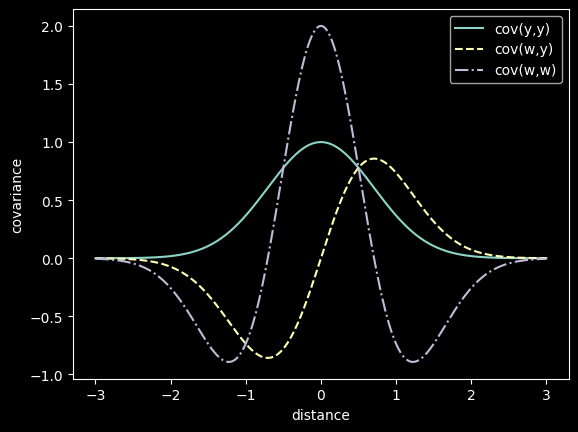

In [7]:
# Figure 1
x = jnp.linspace(-3.0, 3.0, 1000).reshape(-1, 1)
x0 = jnp.array([0.0]).reshape(-1, 1)
params = {"lengthscale": 1.00}

# We are given back the kernel, the kernel derived on first argument, on second argument, and on both arguments
(k, d0k), (d1k, d0d1k) = grad_kernel(se_kernel, argnums=(0, 1))(x0, x, params)

plt.plot(x, k.reshape(-1), label="cov(y,y)")
plt.plot(x, d0k.reshape(-1), ls="--", label="cov(w,y)")
plt.plot(x, d0d1k.reshape(-1), ls="-.", label="cov(w,w)")
plt.xlabel("distance")
plt.ylabel("covariance")
plt.legend()

In [11]:
def derivative_kernel(x1, x2, params):
    """Full derivative kernel

    Returns K:

    K = | cov(y, y)   cov(y, w) |
        | cov(w, y)   cov(w, w) |
    """
    (k, d0_k), (d1_k, d0d1_k) = grad_kernel(se_kernel, argnums=(0, 1))(x1, x2, params)
    return jnp.vstack((jnp.hstack((k, d1_k)), jnp.hstack((d0_k, d0d1_k))))

In [17]:
xx = jnp.linspace(-5.0, 5.0, 200).reshape(-1, 1)
x_obs = jnp.array([[-2.0, -1.0, 2.0]]).T  # observations' locations
y_obs = jnp.array([[1.9, 0.1, -1.9]]).T  # function observations
dy_obs = jnp.array([[-2.0, -1.0, 0.0]]).T  # derivative observations
n_samples = 4  # samples from GP

# 1: sampling from a GPR model with no training
model = GPR(se_kernel, {"lengthscale": 0.5}, 0.000001)
samples_prior = model.sample(random.PRNGKey(0), xx, n_samples=n_samples)

# 2: sampling from a GPR model trained on function observations
model.fit(x_obs, y_obs)
samples_posterior = model.sample(random.PRNGKey(0), xx, n_samples=n_samples)

# 3: sampling from a GPR model trained on function and derivative observations
# note: derivatives go after the function observations, and in the same order
model = GPR(derivative_kernel, {"lengthscale": 0.5}, 0.00001)
model.fit(x_obs, jnp.concatenate((y_obs, dy_obs)))
samples_deriv = model.sample(random.PRNGKey(0), xx, n_samples=n_samples)

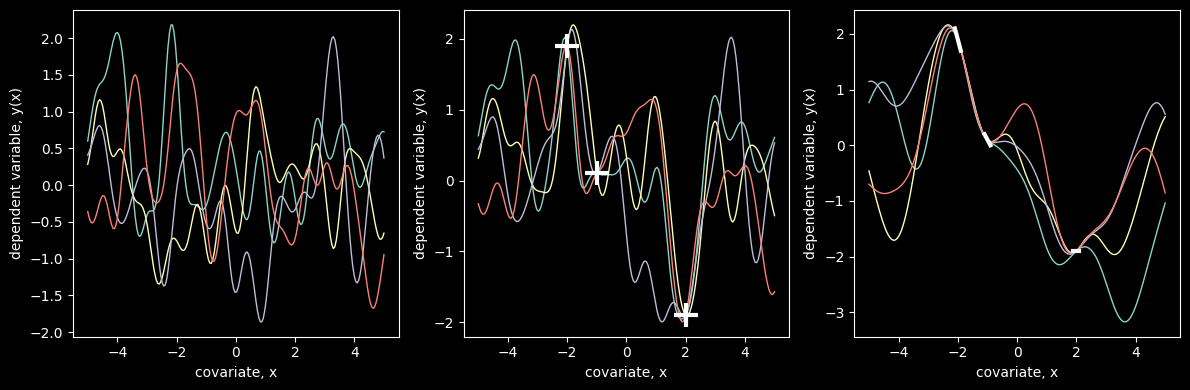

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 4), dpi=100)

# Prior
ax = axes[0]
for sample in samples_prior[0]:
    ax.plot(xx, sample, lw=1)

# Function observations
ax = axes[1]
for sample in samples_posterior[0]:
    ax.plot(xx, sample, lw=1)
ax.scatter(x_obs, y_obs, c="w", marker="+", zorder=99, s=300, lw=3)

# Function plus derivatives
ax = axes[2]
for sample in samples_deriv[0]:
    ax.plot(xx, sample[: len(xx)], lw=1)
for xobs, yobs, dyobs in zip(x_obs, y_obs, dy_obs):
    eps = 0.1
    ax.plot(
        [xobs - eps, xobs + eps], [yobs - dyobs * eps, yobs + dyobs * eps], c="w", lw=3
    )

for ax in axes.flat:
    ax.set_xlabel("covariate, x")
    ax.set_ylabel("dependent variable, y(x)")

fig.tight_layout()